In [1]:
pip install transformers datasets torch captum


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
sample = dataset[0]
print(sample.keys())


NameError: name 'dataset' is not defined

In [ ]:
print(sample["passages"][:3])

In [4]:
dataset = load_dataset("ms_marco", "v2.1", split="train[:100]")

# 2. Load pretrained tokenizer and cross-encoder reranker model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
model.eval()

# 3. Select a sample and extract query + relevant passage
sample = dataset[0]
query = sample["query"]

# Find a relevant (is_selected = 1) passage
for p in sample["passages"]:
    if p["is_selected"] == 1:
        passage = p["passage_text"]
        break
else:
    # Fallback: if no relevant passage marked, use the first
    passage = sample["passages"][0]["passage_text"]

# 4. Tokenize the input pair
inputs = tokenizer(query, passage, return_tensors="pt", truncation=True, padding=True)

# 5. Get prediction score from reranker (class 1 = relevant)
with torch.no_grad():
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    relevance_score = probs[0][1].item()
    print(f"Relevance Score: {relevance_score:.4f}")

# 6. Setup Deep SHAP Explainer
def forward_func(input_ids, attention_mask=None):
    return model(input_ids=input_ids, attention_mask=attention_mask).logits

# Create baseline: all [PAD] tokens
baseline_ids = torch.full_like(inputs['input_ids'], tokenizer.pad_token_id)

# Use DeepLiftShap
explainer = DeepLiftShap(forward_func)

# 7. Compute attributions for relevance
attributions = explainer.attribute(
    inputs['input_ids'],
    baselines=baseline_ids,
    additional_forward_args=(inputs['attention_mask'],)
)

# 8. Sum across embedding dimension and decode tokens
attributions_sum = attributions.sum(dim=-1).squeeze(0)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))

# Print token-wise attributions
print("\nToken Attributions:")
for token, attr in zip(tokens, attributions_sum):
    print(f"{token}: {attr.item():.4f}")

# 9. Visualize attribution scores (heatmap)
viz.visualize_text([viz.VisualizationDataRecord(
    word_attributions=attributions_sum.tolist(),
    pred_prob=relevance_score,
    pred_class='Relevant',
    true_class='Relevant',
    attr_class='Relevant',
    attr_score=attributions_sum.sum().item(),
    raw_input=tokens,
    convergence_score=None
)])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


TypeError: string indices must be integers

In [5]:
sample = dataset[0]
print(sample.keys())


dict_keys(['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'])


In [8]:
dataset = load_dataset("ms_marco", "v2.1", split="train[:100]")

# 2. Load the tokenizer and reranking model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
model.eval()

# 3. Select a sample and extract query and passage correctly
sample = dataset[0]
query = sample["query"]

# 'passages' is a dict, so we extract the first passage using its key
first_passage_key = list(sample["passages"].keys())[0]
passage = sample["passages"][first_passage_key]

# 4. Tokenize the query and passage
inputs = tokenizer(query, passage, return_tensors="pt", truncation=True, padding=True)

# 5. Get the model's relevance prediction
with torch.no_grad():
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    relevance_score = probs[0][1].item()
    print(f"Relevance Score: {relevance_score:.4f}")

# 6. Set up the forward function for Captum
def forward_func(input_ids, attention_mask=None):
    return model(input_ids=input_ids, attention_mask=attention_mask).logits

# 7. Create baseline (all [PAD] tokens)
baseline_ids = torch.full_like(inputs['input_ids'], tokenizer.pad_token_id)

# 8. Run Deep SHAP attribution
explainer = DeepLiftShap(forward_func)
attributions = explainer.attribute(
    inputs['input_ids'],
    baselines=baseline_ids,
    additional_forward_args=(inputs['attention_mask'],)
)

# 9. Decode tokens and sum attribution across embedding dimension
attributions_sum = attributions.sum(dim=-1).squeeze(0)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))

# 10. Print token attributions
print("\nToken Attributions:")
for token, attr in zip(tokens, attributions_sum):
    print(f"{token}: {attr.item():.4f}")

# 11. Visualize attributions with Captum
viz.visualize_text([viz.VisualizationDataRecord(
    word_attributions=attributions_sum.tolist(),
    pred_prob=relevance_score,
    pred_class='Relevant',
    true_class='Relevant',
    attr_class='Relevant',
    attr_score=attributions_sum.sum().item(),
    raw_input=tokens,
    convergence_score=None
)])

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [9]:
print(type(query))
print(type(passage))


<class 'str'>
<class 'list'>


In [1]:
pip install datasets transformers sentence-transformers shap torch


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
from datasets import load_dataset
from sentence_transformers import CrossEncoder
import shap

# Step 1: Load a sample dataset
dataset = load_dataset("ms_marco", "v2.1", split="train[:100]")  # Small subset for demo

# Preprocess: Extract (query, passage, label) tuples
queries = [item['query'] for item in dataset]
passages = [item['passages']['passage_text'][0] for item in dataset]
labels = [1] * len(queries)  # Dummy relevance label: all 1s for demo

# Prepare input pairs
input_pairs = list(zip(queries, passages))

# Step 2: Load CrossEncoder reranker (fine-tuned for MS MARCO)
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# Forward pass (reranking scores)
scores = model.predict(input_pairs)

# Step 3: Explain using Deep SHAP
# Convert pairs to tokenized inputs
tokenizer = model.tokenizer
inputs = tokenizer(input_pairs[:10], padding=True, truncation=True, return_tensors='pt')

# Choose a subset of data to explain
background_inputs = {k: v[:2] for k, v in inputs.items()}
test_inputs = {k: v[2:5] for k, v in inputs.items()}

# Wrap model for SHAP (returns logits directly)
def forward_func(input_ids, attention_mask):
    with torch.no_grad():
        return model.model(input_ids=input_ids, attention_mask=attention_mask).logits

# DeepExplainer
explainer = shap.DeepExplainer(forward_func, [background_inputs['input_ids'], background_inputs['attention_mask']])
shap_values = explainer.shap_values([test_inputs['input_ids'], test_inputs['attention_mask']])

# Visualize
shap.summary_plot(shap_values[0], features=test_inputs['input_ids'].numpy(), feature_names=tokenizer.convert_ids_to_tokens(test_inputs['input_ids'][0]))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


^C
ERROR: Operation cancelled by user


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Step 3: Load CSV files
neural_df = pd.read_csv("neural_rerank_results (1).csv")
bm25_df = pd.read_csv("bm25_results (1).csv")

# Step 4: Restrict both to top 200
neural_top200 = neural_df.groupby("q_id").apply(lambda x: x.sort_values("rank").head(200)).reset_index(drop=True)
bm25_top200 = bm25_df.groupby("q_id").apply(lambda x: x.head(200)).reset_index(drop=True)
bm25_top200["rank"] = bm25_top200.groupby("q_id").cumcount() + 1  # Add rank to BM25

# ✅ Step 5: Drop rows with missing q_data or doc_data
neural_top200 = neural_top200.dropna(subset=["q_data", "doc_data"])
bm25_top200 = bm25_top200.dropna(subset=["q_data", "doc_data"])

# Step 6: Define function with progress bar
def compute_tfidf_similarity(df, label="Processing"):
    results = []
    for q_id, group in tqdm(df.groupby("q_id"), desc=label):
        query = group.iloc[0]["q_data"]
        docs = group["doc_data"].astype(str).tolist()
        ranks = group["rank"].tolist()
        doc_ids = group["doc_id"].tolist()

        # Vectorize query and docs
        texts = [query] + docs
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf = vectorizer.fit_transform(texts)

        query_vec = tfidf[0]
        doc_vecs = tfidf[1:]
        similarities = cosine_similarity(query_vec, doc_vecs).flatten()

        for doc_id, rank, sim in zip(doc_ids, ranks, similarities):
            results.append({
                "q_id": q_id,
                "doc_id": doc_id,
                "similarity_score": sim,
                "similarity_by_rank": sim / rank if rank > 0 else sim
            })
    return pd.DataFrame(results)

# Step 7: Compute similarities
neural_sim_df = compute_tfidf_similarity(neural_top200, label="MonoT5 Neural")
bm25_sim_df = compute_tfidf_similarity(bm25_top200, label="BM25")

# Step 8: Merge into original DataFrames
neural_top200 = pd.merge(neural_top200, neural_sim_df, on=["q_id", "doc_id"])
bm25_top200 = pd.merge(bm25_top200, bm25_sim_df, on=["q_id", "doc_id"])

# Step 9: Save results
neural_top200.to_csv("neural_with_tfidf_similarity.csv", index=False)
bm25_top200.to_csv("bm25_with_tfidf_similarity.csv", index=False)

print("✅ Done! TF-IDF similarity saved to CSV files.")


MonoT5 Neural: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]

BM25: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


✅ Done! TF-IDF similarity saved to CSV files.


In [8]:
neural_sim_df

,q_id,doc_id,similarity_score,similarity_by_rank
0,1,<urn:uuid:8d5ef45a-0258-4116-9456-4cccb92ee022>,0.052952,0.026476
1,1,<urn:uuid:9d73c46e-ef46-449c-9db3-61d03fe68c27>,0.058342,0.019447
2,1,<urn:uuid:fc3cc8d0-efea-433b-886a-2e6d1f995031>,0.056432,0.014108
3,1,<urn:uuid:4e5089f9-64a7-44c3-9867-2a810aa74586>,0.031795,0.006359
4,1,<urn:uuid:c53bf9f4-f352-42ef-8ff0-57caf911271e>,0.122635,0.020439
...,...,...,...,...
467,3,<urn:uuid:417fb664-1d6f-4ff9-965e-021c18b30911>,0.251148,0.003640
468,3,<urn:uuid:396925a3-ed98-48f5-aeca-a5534adbae4f>,0.091378,0.001305
469,3,<urn:uuid:ad4c53fe-7565-4fa6-bce5-538931425b34>,0.048740,0.000686
470,3,<urn:uuid:1cd7d895-caeb-4e92-a87e-06ddc87ed22d>,0.221649,0.003078


In [9]:
bm25_sim_df 

,q_id,doc_id,similarity_score,similarity_by_rank
0,1,<urn:uuid:d671b7ab-5069-49fe-b134-1a9d3c9064cf>,0.241280,0.241280
1,1,<urn:uuid:7ebf6b62-7bcd-4323-ae93-07c059087ee1>,0.238272,0.119136
2,1,<urn:uuid:969e2648-d8bc-4aa6-a36e-fc9dcbfe8aea>,0.212474,0.070825
3,1,<urn:uuid:59a922f1-b92d-4efa-8a94-30be7281dbb3>,0.203428,0.050857
4,1,<urn:uuid:db5b8ce2-0131-4f4f-bd0e-7220e9d28be4>,0.323763,0.064753
...,...,...,...,...
395,2,<urn:uuid:c0cbfc86-8759-4c2f-b7ff-ffa444c03a7a>,0.132788,0.000677
396,2,<urn:uuid:cd74d8fe-343a-46cf-abac-59832061bd5f>,0.132828,0.000674
397,2,<urn:uuid:6efe616d-c382-47a0-81c1-e7fa49ea7ebd>,0.132856,0.000671
398,2,<urn:uuid:d89d1685-0a3d-497e-981e-e1f1d92b47e0>,0.132828,0.000667


In [10]:
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel



Exception ignored in: <function tqdm.__del__ at 0x7f83d8be2c10>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Step 3: Load your CSVs
neural_df = pd.read_csv("neural_rerank_results (1).csv")
bm25_df = pd.read_csv("bm25_results (1).csv")

# Step 4: Restrict both to top 200 and clean NaNs
neural_top200 = neural_df.groupby("q_id").apply(lambda x: x.sort_values("rank").head(200)).reset_index(drop=True)
bm25_top200 = bm25_df.groupby("q_id").apply(lambda x: x.head(200)).reset_index(drop=True)
bm25_top200["rank"] = bm25_top200.groupby("q_id").cumcount() + 1  # Ensure BM25 has rank

# Drop rows with missing values in query or doc
neural_top200 = neural_top200.dropna(subset=["q_data", "doc_data"])
bm25_top200 = bm25_top200.dropna(subset=["q_data", "doc_data"])

# ✅ Step 5: Select the same 10 shared q_ids
shared_qids = list(set(neural_top200['q_id']) & set(bm25_top200['q_id']))
shared_qids.sort()  # Deterministic selection
selected_qids = shared_qids[:2]

# Filter both methods to the same 10 q_ids
neural_sample = neural_top200[neural_top200['q_id'].isin(selected_qids)].copy()
bm25_sample = bm25_top200[bm25_top200['q_id'].isin(selected_qids)].copy()

# Step 6: Load BERT model + tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model = model.to(device)
model.eval()

# Step 7: Define embedding and similarity computation
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

def compute_bert_similarity(df, label="Processing"):
    results = []
    for q_id, group in tqdm(df.groupby("q_id"), desc=label):
        query = group.iloc[0]["q_data"]
        query_vec = get_cls_embedding(query)

        for _, row in group.iterrows():
            doc_vec = get_cls_embedding(str(row["doc_data"]))
            sim = cosine_similarity([query_vec], [doc_vec])[0][0]
            results.append({
                "q_id": q_id,
                "doc_id": row["doc_id"],
                "rank": row["rank"],
                "bert_similarity_score": sim,
                "bert_similarity_by_rank": sim / row["rank"] if row["rank"] > 0 else sim
            })
    return pd.DataFrame(results)

# Step 8: Compute similarity scores for both methods
neural_bert_df = compute_bert_similarity(neural_sample, label="MonoT5 Top 200")
bm25_bert_df = compute_bert_similarity(bm25_sample, label="BM25 Top 200")

# Step 9: Merge scores back into original sample DataFrames
neural_final = pd.merge(neural_sample, neural_bert_df, on=["q_id", "doc_id", "rank"])
bm25_final = pd.merge(bm25_sample, bm25_bert_df, on=["q_id", "doc_id", "rank"])

# Step 10: Save to CSV
neural_final.to_csv("neural_bert_similarity_top10.csv", index=False)
bm25_final.to_csv("bm25_bert_similarity_top10.csv", index=False)

print("✅ Done! BERT similarity scores saved for 10 common queries.")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
BM25 Top 200: 100%|██████████| 2/2 [05:10<00:00, 155.48s/it]


✅ Done! BERT similarity scores saved for 10 common queries.


In [13]:
neural_bert_df

,q_id,doc_id,rank,bert_similarity_score,bert_similarity_by_rank
0,1,<urn:uuid:8d5ef45a-0258-4116-9456-4cccb92ee022>,2,0.537810,0.268905
1,1,<urn:uuid:9d73c46e-ef46-449c-9db3-61d03fe68c27>,3,0.567569,0.189190
2,1,<urn:uuid:fc3cc8d0-efea-433b-886a-2e6d1f995031>,4,0.663885,0.165971
3,1,<urn:uuid:4e5089f9-64a7-44c3-9867-2a810aa74586>,5,0.616579,0.123316
4,1,<urn:uuid:c53bf9f4-f352-42ef-8ff0-57caf911271e>,6,0.711736,0.118623
...,...,...,...,...,...
395,2,<urn:uuid:f954b7c0-6731-4a06-aba2-6d5dc1b4c43c>,197,0.692471,0.003515
396,2,<urn:uuid:71b19f22-60aa-4d7c-b172-0e8e604aa17d>,198,0.679116,0.003430
397,2,<urn:uuid:1cc5a6cd-ec83-44cb-b21e-5895c67e356f>,199,0.700826,0.003522
398,2,<urn:uuid:788e76e1-23b6-426d-aae3-184d073de630>,200,0.736262,0.003681


In [14]:
bm25_final 

,q_id,q_data,doc_id,rank,score,doc_data,bert_similarity_score,bert_similarity_by_rank
0,1,Can vitamin D cure COVID-19?,<urn:uuid:d671b7ab-5069-49fe-b134-1a9d3c9064cf>,1,13.307700,Coronavirus: there are no miracle foods or die...,0.772243,0.772243
1,1,Can vitamin D cure COVID-19?,<urn:uuid:7ebf6b62-7bcd-4323-ae93-07c059087ee1>,2,13.280300,There are no miracle foods or diets that can p...,0.688547,0.344274
2,1,Can vitamin D cure COVID-19?,<urn:uuid:969e2648-d8bc-4aa6-a36e-fc9dcbfe8aea>,3,13.209400,"Sorry, There Are No 'Miracle' Foods or Supplem...",0.668839,0.222946
3,1,Can vitamin D cure COVID-19?,<urn:uuid:59a922f1-b92d-4efa-8a94-30be7281dbb3>,4,13.160200,No Miracle Foods or Diets Can Prevent or Cure ...,0.652346,0.163086
4,1,Can vitamin D cure COVID-19?,<urn:uuid:db5b8ce2-0131-4f4f-bd0e-7220e9d28be4>,5,13.070200,4 false Claims about COVID-19 infection cure |...,0.748419,0.149684
...,...,...,...,...,...,...,...,...
395,2,Can vitamin C cure COVID-19?,<urn:uuid:c0cbfc86-8759-4c2f-b7ff-ffa444c03a7a>,196,11.133797,Former CDC Chief Identifies Possible Way To Cu...,0.789727,0.004029
396,2,Can vitamin C cure COVID-19?,<urn:uuid:cd74d8fe-343a-46cf-abac-59832061bd5f>,197,11.133796,Former CDC Chief Identifies Possible Way To Cu...,0.789727,0.004009
397,2,Can vitamin C cure COVID-19?,<urn:uuid:6efe616d-c382-47a0-81c1-e7fa49ea7ebd>,198,11.133795,Former CDC Chief Identifies Possible Way To Cu...,0.789727,0.003989
398,2,Can vitamin C cure COVID-19?,<urn:uuid:d89d1685-0a3d-497e-981e-e1f1d92b47e0>,199,11.133794,Former CDC Chief Identifies Possible Way To Cu...,0.789727,0.003968


In [18]:
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel

# Step 3: Load and filter data
neural_df = pd.read_csv("neural_rerank_results (1).csv")
bm25_df = pd.read_csv("bm25_results (1).csv")

neural_top200 = neural_df.groupby("q_id").apply(lambda x: x.sort_values("rank").head(200)).reset_index(drop=True)
bm25_top200 = bm25_df.groupby("q_id").apply(lambda x: x.head(200)).reset_index(drop=True)
bm25_top200["rank"] = bm25_top200.groupby("q_id").cumcount() + 1

neural_top200 = neural_top200.dropna(subset=["q_data", "doc_data"])
bm25_top200 = bm25_top200.dropna(subset=["q_data", "doc_data"])

shared_qids = list(set(neural_top200['q_id']) & set(bm25_top200['q_id']))
shared_qids.sort()
selected_qids = shared_qids[:10]

neural_sample = neural_top200[neural_top200['q_id'].isin(selected_qids)].copy()
bm25_sample = bm25_top200[bm25_top200['q_id'].isin(selected_qids)].copy()

# Step 4: Load BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.to(device).eval()

# Step 5: Helper to extract [CLS] embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

# Step 6: Compute cosine similarity between query and documents
def compute_bert_similarity(df, label="Processing"):
    results = []
    for q_id, group in tqdm(df.groupby("q_id"), desc=label):
        query = group.iloc[0]["q_data"]
        query_vec = get_cls_embedding(query)
        for _, row in tqdm(group.iterrows(), total=len(group), desc=f"→ Docs for q_id {q_id}", leave=False):
            doc_vec = get_cls_embedding(str(row["doc_data"]))
            sim = cosine_similarity([query_vec], [doc_vec])[0][0]
            results.append({
                "q_id": q_id,
                "doc_id": row["doc_id"],
                "rank": row["rank"],
                "bert_similarity_score": sim
            })
    return pd.DataFrame(results)

# Step 7: Generate and merge BERT scores
neural_bert_df = compute_bert_similarity(neural_sample, label="MonoT5 Top 200")
bm25_bert_df = compute_bert_similarity(bm25_sample, label="BM25 Top 200")

neural_final = pd.merge(neural_sample, neural_bert_df, on=["q_id", "doc_id", "rank"])
bm25_final = pd.merge(bm25_sample, bm25_bert_df, on=["q_id", "doc_id", "rank"])

# Step 8: Compute similarity_by_rank and summarize per query
neural_final["bert_similarity_by_rank"] = neural_final["bert_similarity_score"] / neural_final["rank"]
bm25_final["bert_similarity_by_rank"] = bm25_final["bert_similarity_score"] / bm25_final["rank"]

neural_summary = neural_final.groupby("q_id")["bert_similarity_by_rank"].sum().reset_index()
bm25_summary = bm25_final.groupby("q_id")["bert_similarity_by_rank"].sum().reset_index()

neural_summary.columns = ["q_id", "neural_total_similarity_by_rank"]
bm25_summary.columns = ["q_id", "bm25_total_similarity_by_rank"]

summary_comparison = pd.merge(neural_summary, bm25_summary, on="q_id")

# Step 9: Save final comparison
summary_comparison.to_csv("summed_similarity_by_rank_comparison.csv", index=False)
print("✅ Done! Saved as 'summed_similarity_by_rank_comparison.csv'")
display(summary_comparison)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
BM25 Top 200: 100%|██████████| 2/2 [05:40<00:00, 170.07s/it]        

✅ Done! Saved as 'summed_similarity_by_rank_comparison.csv'


,q_id,neural_total_similarity_by_rank,bm25_total_similarity_by_rank
0,1,3.154379,4.232623
1,2,3.155072,4.254767


In [19]:
summary_comparison

,q_id,neural_total_similarity_by_rank,bm25_total_similarity_by_rank
0,1,3.154379,4.232623
1,2,3.155072,4.254767


In [20]:
print("Neural top200 unique q_ids:", neural_top200['q_id'].nunique())
print("BM25 top200 unique q_ids:", bm25_top200['q_id'].nunique())
print("Shared q_ids count:", len(shared_qids))
print("Shared q_ids:", shared_qids[:10])


Neural top200 unique q_ids: 3
BM25 top200 unique q_ids: 2
Shared q_ids count: 2
Shared q_ids: [1, 2]


In [21]:
neural_df

,q_id,q_data,doc_id,rank,score,tokens,attention_mask,token_type,doc_data
0,1,Can vitamin D cure COVID-19?,<urn:uuid:8d5ef45a-0258-4116-9456-4cccb92ee022>,2,-0.000146,"tensor([ 451, 7249, 659, 30, 10368, 3...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,Shedding light on Vitamin D: Is there a connec...
1,1,Can vitamin D cure COVID-19?,<urn:uuid:9d73c46e-ef46-449c-9db3-61d03fe68c27>,3,-0.000204,"tensor([10368, 7, 205, 6, 309, ...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,"Vitamins C, D can help prevent coronavirus, Or..."
2,1,Can vitamin D cure COVID-19?,<urn:uuid:fc3cc8d0-efea-433b-886a-2e6d1f995031>,4,-0.002419,"tensor([ 571, 12, 4888, 39, 9392, 3...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,How to boost your immune system during the cor...
3,1,Can vitamin D cure COVID-19?,<urn:uuid:4e5089f9-64a7-44c3-9867-2a810aa74586>,5,-0.003382,"tensor([28045, 18095, 10, 1008, 22, ...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,Coronavirus: Dont dismiss Oonis herbal cure cl...
4,1,Can vitamin D cure COVID-19?,<urn:uuid:c53bf9f4-f352-42ef-8ff0-57caf911271e>,6,-0.003603,"tensor([ 305, 1832, 12128, 12, 199, ...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,5 essential nutrients to help your immune syst...
...,...,...,...,...,...,...,...,...,...
9995,50,Can drinking lemon water prevent COVID-19?,<urn:uuid:5b7e7d1e-6c4c-4c40-9675-e23fc2e8570c>,197,-8.013968,"tensor([ 4486, 17833, 8747, 134, 10, 4...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,NaN
9996,50,Can drinking lemon water prevent COVID-19?,<urn:uuid:ab12ebef-84c9-4549-ba70-c27e7ed37260>,198,-8.042397,"tensor([ 4486, 17833, 8747, 134, 10, 107...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,NaN
9997,50,Can drinking lemon water prevent COVID-19?,<urn:uuid:bc2f9a3f-3036-443e-86bf-6466868232aa>,199,-8.220665,"tensor([ 465, 6, 25, 54, 31, ...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,NaN
9998,50,Can drinking lemon water prevent COVID-19?,<urn:uuid:ba0a31d5-3f85-4ead-a937-6f4a514c2081>,200,-8.411972,"tensor([ 465, 6, 25, 54, 31, ...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,NaN


In [24]:


# Step 2: Imports
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel

# Step 3: Load CSVs
neural_df = pd.read_csv("neural_rerank_results (1).csv")
bm25_df = pd.read_csv("bm25_results (1).csv")

# Step 4: Clean missing values and ensure rank exists
#neural_df = neural_df.dropna(subset=["q_id", "q_data", "doc_id", "doc_data", "rank"])
#bm25_df = bm25_df.dropna(subset=["q_id", "q_data", "doc_id", "doc_data"])
neural_df["rank"] = pd.to_numeric(neural_df["rank"], errors="coerce")
bm25_df["rank"] = bm25_df.groupby("q_id").cumcount() + 1  # Assign rank if not present

# Step 5: Select shared q_ids and filter to top 10
shared_qids = sorted(list(set(neural_df["q_id"]) & set(bm25_df["q_id"])))
selected_qids = shared_qids[:5]

# Step 6: Select top 200 docs per query based on rank
neural_top200 = (
    neural_df[neural_df["q_id"].isin(selected_qids)]
    .sort_values(["q_id", "rank"])
    .groupby("q_id")
    .head(200)
    .reset_index(drop=True)
)

bm25_top200 = (
    bm25_df[bm25_df["q_id"].isin(selected_qids)]
    .sort_values(["q_id", "rank"])
    .groupby("q_id")
    .head(200)
    .reset_index(drop=True)
)

# Step 7: Load BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model = model.to(device).eval()

# Step 8: Define helper to get [CLS] embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

# Step 9: Compute BERT similarity for all docs
def compute_bert_similarity(df, label="Processing"):
    results = []
    for q_id, group in tqdm(df.groupby("q_id"), desc=f"{label}"):
        query = group.iloc[0]["q_data"]
        query_vec = get_cls_embedding(query)
        for _, row in tqdm(group.iterrows(), total=len(group), desc=f"→ Docs for q_id {q_id}", leave=False):
            doc_vec = get_cls_embedding(str(row["doc_data"]))
            sim = cosine_similarity([query_vec], [doc_vec])[0][0]
            results.append({
                "q_id": q_id,
                "doc_id": row["doc_id"],
                "rank": row["rank"],
                "bert_similarity_score": sim
            })
    return pd.DataFrame(results)

# Step 10: Apply to both methods
neural_bert_df = compute_bert_similarity(neural_top200, label="MonoT5")
bm25_bert_df = compute_bert_similarity(bm25_top200, label="BM25")

# Step 11: Merge similarity scores back
neural_final = pd.merge(neural_top200, neural_bert_df, on=["q_id", "doc_id", "rank"])
bm25_final = pd.merge(bm25_top200, bm25_bert_df, on=["q_id", "doc_id", "rank"])

# Step 12: Calculate similarity-by-rank
neural_final["bert_similarity_by_rank"] = neural_final["bert_similarity_score"] / neural_final["rank"]
bm25_final["bert_similarity_by_rank"] = bm25_final["bert_similarity_score"] / bm25_final["rank"]

# Step 13: Summarize per query (10 scores per method)
neural_summary = neural_final.groupby("q_id")["bert_similarity_by_rank"].sum().reset_index()
bm25_summary = bm25_final.groupby("q_id")["bert_similarity_by_rank"].sum().reset_index()
neural_summary.columns = ["q_id", "neural_total_similarity_by_rank"]
bm25_summary.columns = ["q_id", "bm25_total_similarity_by_rank"]

# Step 14: Save and display
neural_summary.to_csv("neural_summary_top10.csv", index=False)
bm25_summary.to_csv("bm25_summary_top10.csv", index=False)

print("✅ Done! Summed similarity-by-rank scores saved for 10 queries.")
display(neural_summary)
display(bm25_summary)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
BM25: 100%|██████████| 5/5 [05:55<00:00, 71.03s/it]                 


✅ Done! Summed similarity-by-rank scores saved for 10 queries.


,q_id,neural_total_similarity_by_rank
0,1,3.154379
1,2,3.155072
2,3,3.173603
3,4,3.457755
4,5,3.592179


,q_id,bm25_total_similarity_by_rank
0,1,4.232623
1,2,4.254767
2,3,4.116462
3,4,4.162353
4,5,4.324168


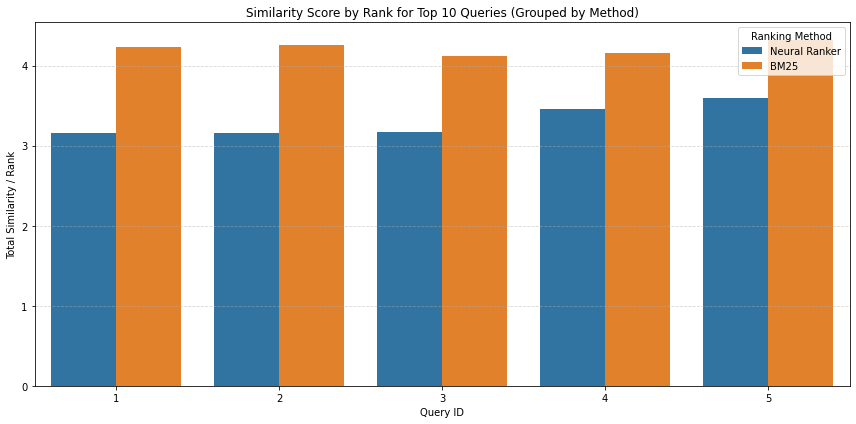

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load provided summaries
neural_summary = pd.read_csv("neural_summary_top10.csv")
bm25_summary = pd.read_csv("bm25_summary_top10.csv")

# Merge on q_id
merged_summary = pd.merge(neural_summary, bm25_summary, on="q_id")

# Melt the DataFrame to long format for easier plotting
plot_df = pd.melt(
    merged_summary,
    id_vars=["q_id"],
    value_vars=["neural_total_similarity_by_rank", "bm25_total_similarity_by_rank"],
    var_name="Method",
    value_name="Similarity_by_Rank"
)

# Clean up method names for better plot labels
plot_df["Method"] = plot_df["Method"].replace({
    "neural_total_similarity_by_rank": "Neural Ranker",
    "bm25_total_similarity_by_rank": "BM25"
})

# Create grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="q_id", y="Similarity_by_Rank", hue="Method")

plt.xlabel("Query ID")
plt.ylabel("Total Similarity / Rank")
plt.title("Similarity Score by Rank for Top 10 Queries (Grouped by Method)")
plt.legend(title="Ranking Method")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


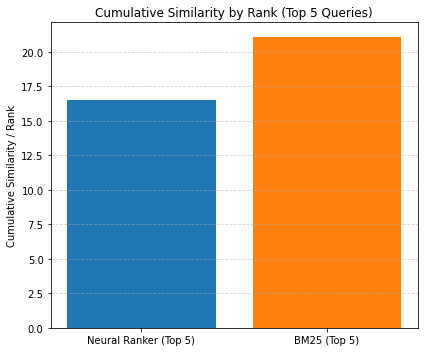

In [30]:
# Use first 5 queries from the merged summary
merged_summary_top5 = merged_summary[merged_summary["q_id"].isin([1, 2, 3, 4, 5])]

# Sum up similarity scores for top 5 queries
cumulative_top5 = {
    "Neural Ranker (Top 5)": merged_summary_top5["neural_total_similarity_by_rank"].sum(),
    "BM25 (Top 5)": merged_summary_top5["bm25_total_similarity_by_rank"].sum(),
}

# Plot cumulative similarity by rank for top 5 queries
plt.figure(figsize=(6, 5))
plt.bar(cumulative_top5.keys(), cumulative_top5.values(), color=["tab:blue", "tab:orange"])
plt.title("Cumulative Similarity by Rank (Top 5 Queries)")
plt.ylabel("Cumulative Similarity / Rank")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


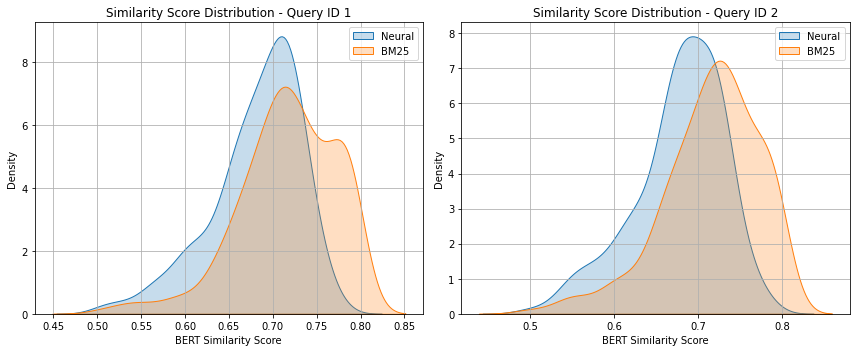

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for only queries 1 and 2
neural_filtered = neural_final[neural_final["q_id"].isin([1, 2])]
bm25_filtered = bm25_final[bm25_final["q_id"].isin([1, 2])]

# Plot distribution of similarity score for each query and method
plt.figure(figsize=(12, 5))
for i, qid in enumerate([1, 2], 1):
    plt.subplot(1, 2, i)
    sns.kdeplot(neural_filtered[neural_filtered["q_id"] == qid]["bert_similarity_score"], label="Neural", fill=True)
    sns.kdeplot(bm25_filtered[bm25_filtered["q_id"] == qid]["bert_similarity_score"], label="BM25", fill=True)
    plt.title(f"Similarity Score Distribution - Query ID {qid}")
    plt.xlabel("BERT Similarity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
